In [1]:
from langchain_openai import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

__import__('pysqlite3')
import sys
sys.modules['sqlite3'] = sys.modules.pop('pysqlite3')

In [2]:
loader = DirectoryLoader('./', glob="./data/*.txt", loader_cls=TextLoader)
docs = loader.load()

In [3]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=100,
    chunk_overlap=10,
    length_function=len
)
new_docs = text_splitter.split_documents(documents=docs)
doc_strings = [doc.page_content for doc in new_docs]

In [4]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
vectors = embeddings.embed_documents(doc_strings)

In [5]:
db = Chroma.from_documents(new_docs, embeddings)
retriever = db.as_retriever(search_kwargs={"k": 6})

In [6]:
import umap
import numpy as np
from tqdm import tqdm

umap_transformer = umap.UMAP(random_state=0, transform_seed=0).fit(vectors)

/usr/local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [8]:
def umap_embed(vectors, umap_transformer):
    umap_embeddings = np.array([umap_transformer.transform([vector])[0] for vector in tqdm(vectors)])
    return umap_embeddings

In [9]:
global_embeddings = umap_embed(vectors, umap_transformer)

100%|██████████| 63/63 [00:54<00:00,  1.16it/s]


In [10]:
global_embeddings

array([[ 2.9165823 ,  1.200334  ],
       [ 3.711599  ,  3.0885901 ],
       [ 2.7367675 ,  1.129692  ],
       [ 0.22712027,  3.0107708 ],
       [ 2.5457284 ,  3.5268698 ],
       [ 2.2429779 ,  1.1581837 ],
       [ 0.5123389 ,  3.3433192 ],
       [ 2.1722987 ,  3.9286509 ],
       [ 1.3794788 ,  4.015376  ],
       [ 0.63424367,  3.6070254 ],
       [ 2.5518389 ,  1.0997329 ],
       [ 0.28760117,  1.8052742 ],
       [ 0.6060534 ,  1.4936284 ],
       [ 0.6577569 ,  1.4636978 ],
       [ 2.1603684 ,  1.228075  ],
       [ 1.1743997 ,  1.1958977 ],
       [ 0.5251845 ,  3.3578773 ],
       [ 0.52554923,  3.3729181 ],
       [ 2.8883977 ,  3.5761347 ],
       [ 2.2311535 ,  1.1733662 ],
       [ 1.3003398 ,  1.18875   ],
       [ 0.7539505 ,  1.4390622 ],
       [ 3.2737029 ,  1.4484979 ],
       [ 0.5015563 ,  1.573985  ],
       [ 3.1433957 ,  1.3587598 ],
       [ 2.9838667 ,  3.20721   ],
       [ 3.819942  ,  2.8838995 ],
       [ 3.506981  ,  2.1526268 ],
       [ 2.8843186 ,

(-0.2856045700609684,
 10.994341809302568,
 0.6748028993606567,
 10.02326238155365)

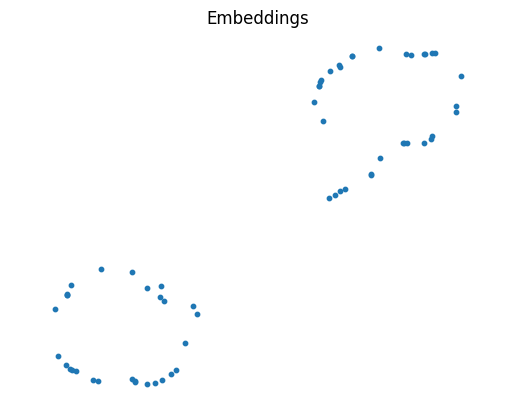

In [11]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(global_embeddings[:, 0], global_embeddings[:, 1], s=10)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Embeddings')
plt.axis('off')

In [12]:
def calc_global_embeddings(query, embeddings, retriever, umap_transformer, embed_function, global_embeddings):
    q_embedding = embeddings.embed_query(query)

    docs = retriever.get_relevant_documents(query)
    page_contents = [doc.page_content for doc in docs]
    vectors_content_vectors = embeddings.embed_documents(page_contents)

    query_embeddings = embed_function([q_embedding], umap_transformer)
    retrieved_embeddings = embed_function(vectors_content_vectors, umap_transformer)

    plt.figure()
    plt.scatter(global_embeddings[:, 0], global_embeddings[:, 1], s=10, color='gray')
    plt.scatter(query_embeddings[:, 0], query_embeddings[:, 1], s=150, marker='X', color='r')
    plt.scatter(retrieved_embeddings[:, 0], retrieved_embeddings[:, 1], s=50, facecolors='none', edgecolors='g')
    plt.gca().set_aspect('equal', 'datalim')
    plt.title(f'{query}')
    plt.axis('off')
    plt.show()


100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


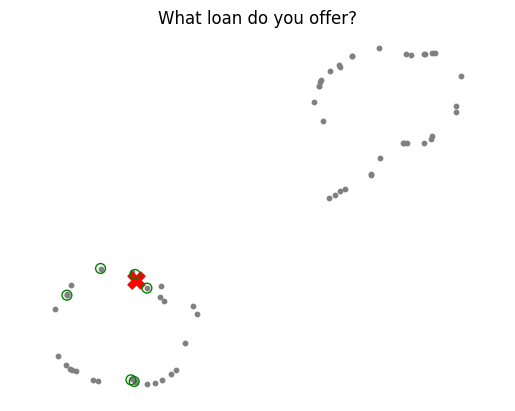

In [13]:
calc_global_embeddings("What loan do you offer?", embeddings, retriever, umap_transformer, umap_embed, global_embeddings)

100%|██████████| 6/6 [00:05<00:00,  1.16it/s]


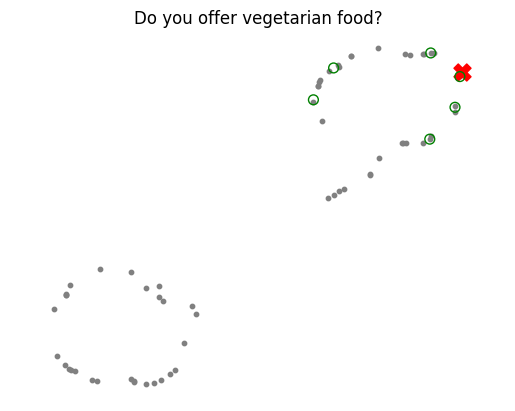

In [14]:
calc_global_embeddings("Do you offer vegetarian food?", embeddings, retriever, umap_transformer, umap_embed, global_embeddings)


### Query Expansion 

In [16]:
from langchain.chat_models import ChatOpenAI

llm = ChatOpenAI(
        temperature=0,
        max_tokens=800,
        model_kwargs={"top_p": 0, "frequency_penalty": 0, "presence_penalty": 0},
    )


In [22]:
from langchain.chains import LLMChain
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import PromptTemplate
from pydantic import BaseModel, Field

query = "Do you offer vegetarian food?"

class LineList(BaseModel):
    lines: list[str] = Field(description="Lines of text")



QUERY_PROMPT = PromptTemplate(
    input_variables=["question"],
    template="""You are an AI language model assistant. Your task is to generate five
    different versions of the given user question to retrieve relevant documents from a vector
    database. By generating multiple perspectives on the user question, your goal is to help
    the user overcome some of the limitations of the distance-based similarity search.
    Provide these alternative questions separated by newlines. Only provide the query, no numbering.
    Original question: {question}""",
)

llm_chain = LLMChain(llm=llm, prompt=QUERY_PROMPT)
queries = llm_chain.invoke(query)
queries = queries.get("text").strip().split("\n")
queries

['Do you provide plant-based meal options?',
 'Are vegetarian dishes available on your menu?',
 'Do you have any meatless food choices?',
 'Are there vegetarian-friendly options on your menu?',
 'Do you cater to customers looking for vegetarian meals?']

In [24]:
docs = [retriever.get_relevant_documents(query) for query in queries]


[[Document(page_content='La Bella Vita also prides itself on its vegetarian and vegan options, catering to all dietary', metadata={'source': 'data/data2.txt'}),
  Document(page_content='dietary preferences. Dishes like eggplant parmigiana and mushroom risotto are crafted with the same', metadata={'source': 'data/data2.txt'}),
  Document(page_content='the same attention to detail and flavor as their meat-based counterparts.', metadata={'source': 'data/data2.txt'}),
  Document(page_content='La Bella Vita also offers a unique dining experience with its private dining rooms and catering', metadata={'source': 'data/data2.txt'}),
  Document(page_content='the restaurant provides a personalized service that makes every event memorable.', metadata={'source': 'data/data2.txt'}),
  Document(page_content='cooking expertise to the table. The menu features a variety of regional specialties, showcasing the', metadata={'source': 'data/data2.txt'})],
 [Document(page_content='dietary preferences. Dishes

In [25]:
unique_contents = set()
unique_docs = []
for sublist in docs:
    for doc in sublist:
        if doc.page_content not in unique_contents:
            unique_docs.append(doc)
            unique_contents.add(doc.page_content)
unique_contents = list(unique_contents)

In [26]:
unique_contents

["catering services. Whether it's for a special occasion, a business meeting, or a family gathering,",
 'The meat and fish dishes are equally impressive, with offerings like osso buco, saltimbocca, and',
 'the same attention to detail and flavor as their meat-based counterparts.',
 'dietary preferences. Dishes like eggplant parmigiana and mushroom risotto are crafted with the same',
 'the restaurant provides a personalized service that makes every event memorable.',
 'La Bella Vita also prides itself on its vegetarian and vegan options, catering to all dietary',
 'cooking expertise to the table. The menu features a variety of regional specialties, showcasing the',
 'The pasta selection is a highlight of the menu, featuring classics like lasagna, ravioli, and',
 'from rich and creamy to light and zesty, are made with the freshest ingredients, bringing out the',
 'La Bella Vita also offers a unique dining experience with its private dining rooms and catering']

# Cross-encoder re-ranking

In [27]:
from sentence_transformers import CrossEncoder
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

In [28]:
pairs = []
for doc in unique_contents:
    pairs.append([query, doc])

pairs

[['Do you offer vegetarian food?',
  "catering services. Whether it's for a special occasion, a business meeting, or a family gathering,"],
 ['Do you offer vegetarian food?',
  'The meat and fish dishes are equally impressive, with offerings like osso buco, saltimbocca, and'],
 ['Do you offer vegetarian food?',
  'the same attention to detail and flavor as their meat-based counterparts.'],
 ['Do you offer vegetarian food?',
  'dietary preferences. Dishes like eggplant parmigiana and mushroom risotto are crafted with the same'],
 ['Do you offer vegetarian food?',
  'the restaurant provides a personalized service that makes every event memorable.'],
 ['Do you offer vegetarian food?',
  'La Bella Vita also prides itself on its vegetarian and vegan options, catering to all dietary'],
 ['Do you offer vegetarian food?',
  'cooking expertise to the table. The menu features a variety of regional specialties, showcasing the'],
 ['Do you offer vegetarian food?',
  'The pasta selection is a highl

In [29]:
scores = cross_encoder.predict(pairs)
scores

array([-11.1671715,  -8.007283 , -10.356451 ,  -9.750739 , -10.895904 ,
        -2.7005734, -11.102642 , -10.774685 , -10.663025 , -11.079877 ],
      dtype=float32)

In [30]:
scored_docs = zip(scores, unique_contents)
sorted_docs = sorted(scored_docs, reverse=True)
sorted_docs

[(-2.7005734,
  'La Bella Vita also prides itself on its vegetarian and vegan options, catering to all dietary'),
 (-8.007283,
  'The meat and fish dishes are equally impressive, with offerings like osso buco, saltimbocca, and'),
 (-9.750739,
  'dietary preferences. Dishes like eggplant parmigiana and mushroom risotto are crafted with the same'),
 (-10.356451,
  'the same attention to detail and flavor as their meat-based counterparts.'),
 (-10.663025,
  'from rich and creamy to light and zesty, are made with the freshest ingredients, bringing out the'),
 (-10.774685,
  'The pasta selection is a highlight of the menu, featuring classics like lasagna, ravioli, and'),
 (-10.895904,
  'the restaurant provides a personalized service that makes every event memorable.'),
 (-11.079877,
  'La Bella Vita also offers a unique dining experience with its private dining rooms and catering'),
 (-11.102642,
  'cooking expertise to the table. The menu features a variety of regional specialties, showca

In [31]:
reranked_docs = [doc for _, doc in sorted_docs][0:8]
reranked_docs

['La Bella Vita also prides itself on its vegetarian and vegan options, catering to all dietary',
 'The meat and fish dishes are equally impressive, with offerings like osso buco, saltimbocca, and',
 'dietary preferences. Dishes like eggplant parmigiana and mushroom risotto are crafted with the same',
 'the same attention to detail and flavor as their meat-based counterparts.',
 'from rich and creamy to light and zesty, are made with the freshest ingredients, bringing out the',
 'The pasta selection is a highlight of the menu, featuring classics like lasagna, ravioli, and',
 'the restaurant provides a personalized service that makes every event memorable.',
 'La Bella Vita also offers a unique dining experience with its private dining rooms and catering']

### Lost in the middle Problem

In [32]:
from langchain_community.document_transformers import (
    LongContextReorder
)

In [33]:
reordering = LongContextReorder()
reordered_docs = reordering.transform_documents(reranked_docs)
reordered_docs

['The meat and fish dishes are equally impressive, with offerings like osso buco, saltimbocca, and',
 'the same attention to detail and flavor as their meat-based counterparts.',
 'The pasta selection is a highlight of the menu, featuring classics like lasagna, ravioli, and',
 'La Bella Vita also offers a unique dining experience with its private dining rooms and catering',
 'the restaurant provides a personalized service that makes every event memorable.',
 'from rich and creamy to light and zesty, are made with the freshest ingredients, bringing out the',
 'dietary preferences. Dishes like eggplant parmigiana and mushroom risotto are crafted with the same',
 'La Bella Vita also prides itself on its vegetarian and vegan options, catering to all dietary']